# XGBoost Classification Analysis of Wind Turbine Data

1. [Imports.](#Cell1)
1. [Load preprocessed training data set and split it into training and testing data frames, separately for each turbine.](#Cell2)
1. [Set some defaults values for classifier hyper-parameters.](#Cell3)
1. [Fit xgb model and monitor performance as trees are added.](#Cell4)
1. [Tune the number and size of trees using cross-validation.](#Cell5)
1. [Tune the learning rate and the number of trees using cross-validation.](#Cell6)
1. [Tune the row subsampling.](#Cell7)
1. [Tune the column subsampling by tree.](#Cell8)
1. [Tune the column subsampling by split.](#Cell9)
1. [Tune the alpha regularization parameter.](#Cell10)
1. [Tune the lambda regularization parameter.](#Cell11)
1. [Create separate models for each of the ten turbines, using cross-validation.](#Cell12)
1. [Retrieve from disk models that were trained on the training subsample only.](#Cell13)
1. [Test the fitted models on the testing subset.](#Cell14)
1. [Plot feature importances averaged over all turbines.](#Cell15)
1. [Compare classifier and regressor on their ability to identify zero turbine output events in the test set.](#Cell16)
1. [Compute RMSE on test set, with and without the classifier correction, and compare.](#Cell17)
1. [Refit model with final settings to entire training data set and save fitted model to disk.](#Cell18)
1. [Retrieve trained models from disk.](#Cell19)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell20)

<a id='Cell1'></a>

In [1]:
'''
Imports.
'''
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.externals import joblib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from blagging import BlaggingClassifier
import matplotlib.pyplot as plt
from time import strftime
from datetime import datetime
from operator import itemgetter
import csv

<a id='Cell2'></a>

In [2]:
'''
Load preprocessed training data set and split it into training and testing data frames, separately for each turbine.
'''
# Select training set size and preprocessed data file
N_train = 10000
#TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl"
#TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl" # Rolling means over 3 measurements
TrainingDataFile = "data/Train_pp_2017_03_27_17_43_43.pkl" # rm=3, dups removed

# Load data, make a copy
df0 = pd.read_pickle(TrainingDataFile)
df1 = df0.copy()
print('Shape of loaded data frame: {0}'.format(df0.shape))

# Rename dataframe columns and make lists with the new predictor and target labels
predictors  = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]!='TARGETVAR']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
targets     = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]=='TARGETVAR']
df0.columns = targets+predictors
df1.columns = targets+predictors
print('\nPredictor variables: {0}\n'.format(predictors))

# Replace target values in df0 with binary labels for classification.
pos = 1
for target in targets:
    df0[target] = df0[target].map(lambda x: pos if x==0 else 1-pos)

# Split data set into training and testing subsets
dfs_train_X = []
dfs_test_X  = []
dfs_train_y = []
dfs_test_y  = []
dfs_test_yt = []
for target in targets:
    df_train_X, df_test_X, df_train_y, df_test_y, df_train_yt, df_test_yt \
    = train_test_split(df0[predictors], df0[target], df1[target], 
                       stratify=df0[target], train_size=N_train, random_state=0)
    dfs_train_X.append(df_train_X)
    dfs_test_X.append(df_test_X)
    dfs_train_y.append(df_train_y)
    dfs_test_y.append(df_test_y)
    dfs_test_yt.append(df_test_yt)

# Print out the data frame shapes
for ind, (df_train_X, df_train_y, df_test_X, df_test_y) \
in enumerate(zip(dfs_train_X, dfs_train_y, dfs_test_X, dfs_test_y)):
    turbine = ind + 1
    print('Turbine {0:2d} data frame shapes: train_X: {1}, train_y: {2}, test_X: {3}, test_y: {4}'\
          .format(turbine, df_train_X.shape, df_train_y.shape, df_test_X.shape, df_test_y.shape))

# Print out the class distributions in the full, training, and test data sets.
zeroes_all      = np.array([df0[df0[target]==pos][target].count() for target in targets]).astype(float)
zeroes_all_pc   = [round(x,1) for x in 100*zeroes_all/len(df0)]
zeroes_train    = np.array([df_train_y[df_train_y==pos].count() for df_train_y in dfs_train_y]).astype(float)
zeroes_train_pc = [round(x,1) for x in 100*zeroes_train/len(df_train_y)]
zeroes_test     = np.array([df_test_y[df_test_y==pos].count() for df_test_y in dfs_test_y]).astype(float)
zeroes_test_pc  = [round(x,1) for x in 100*zeroes_test/len(df_test_y)]
print('\nPercentage of zero turbine outputs in full data set:  {0}'.format(zeroes_all_pc))
print('Percentage of zero turbine outputs in train data set: {0}'.format(zeroes_train_pc))
print('Percentage of zero turbine outputs in test data set:  {0}'.format(zeroes_test_pc))

Shape of loaded data frame: (13871, 45)

Predictor variables: ['U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']

Turbine  1 data frame shapes: train_X: (10000, 35), train_y: (10000,), test_X: (3871, 35), test_y: (3871,)
Turbine  2 data frame shapes: train_X: (10000, 35), train_y: (10000,), test_X: (3871, 35), test_y: (3871,)
Turbine  3 data frame shapes: train_X: (10000, 35), train_y: (10000,), test_X: (3871, 35), test_y: (3871,)
Turbine  4 data frame shapes: train_X: (10000, 35), train_y: (10000,), test_X: (3871, 35), test_y: (3871,)
Turbine  5 data frame shapes: train_X: (100

## Explore parameter space

<a id='Cell3'></a>

In [4]:
'''
Set some defaults values for classifier hyper-parameters.
'''

defaults = {'objective': 'binary:logistic', 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.1, 
            'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 
            'reg_alpha': 0, 'reg_lambda': 1, 
            'seed': 0, 'nthread': -1, 'silent': True}

turbine    = 1
df_train_X = dfs_train_X[turbine-1]
df_train_y = dfs_train_y[turbine-1]
df_test_X  = dfs_test_X[turbine-1]
df_test_y  = dfs_test_y[turbine-1]
evmetric   = 'logloss'
threshold  = 0.50

<a id='Cell4'></a>

CPU times: user 1min 16s, sys: 1.02 s, total: 1min 17s
Wall time: 1min 21s
Algorithm: XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Log-Loss on Test Set at Best Iteration:  0.146001, Number of Trees: 591
Log-Loss on Test Set at Final Iteration: 0.17112, Number of Trees: 2000
Test Set Accuracy: 0.948592095066


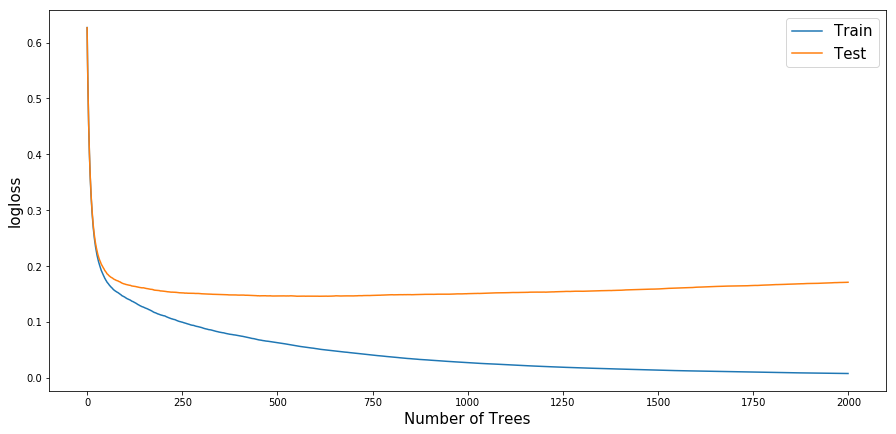

In [5]:
'''
Fit xgb model and monitor performance as trees are added.
'''
%matplotlib inline

# Fit model to training data
xgb1     = XGBClassifier(**defaults)
eval_set = [(df_train_X, df_train_y), 
            (df_test_X, df_test_y)]
%time xgb1.fit(df_train_X, df_train_y, eval_metric=evmetric, eval_set=eval_set, verbose=False)

# Make predictions for test data
df_test_yprob = xgb1.predict_proba(df_test_X)
df_test_ypred = [1 if prob>=threshold else 0 for (_,prob) in df_test_yprob]

# Retrieve performance metrics
results             = xgb1.evals_result()
min_index, min_lolo = min(enumerate(results['validation_1'][evmetric]), key=itemgetter(1))
n_trees_best        = min_index + 1
n_trees_final       = len(results['validation_1'][evmetric])
lolo_test           = results['validation_1'][evmetric][-1]
accuracy            = accuracy_score(df_test_y, df_test_ypred)
print('Algorithm: {0}'.format(xgb1))
print("Log-Loss on Test Set at Best Iteration:  {0}, Number of Trees: {1}".format(min_lolo, n_trees_best))
print("Log-Loss on Test Set at Final Iteration: {0}, Number of Trees: {1}".format(lolo_test, n_trees_final))
print("Test Set Accuracy: {0}".format(accuracy))

#  Plot learning curves
epochs = len(results['validation_0'][evmetric])
x_axis = range(0, epochs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.plot(x_axis, results['validation_0'][evmetric], label='Train')
axis.plot(x_axis, results['validation_1'][evmetric], label='Test')
axis.legend(fontsize=15)
axis.set_xlabel('Number of Trees', fontsize=15)
axis.set_ylabel(evmetric, fontsize=15)
plt.show()

<a id='Cell5'></a>

CPU times: user 1.11 s, sys: 227 ms, total: 1.34 s
Wall time: 9min 49s

Best score: 0.149490632497, using {'n_estimators': 350, 'max_depth': 6}

0.151249714765 +/- 0.00260861088061, with {'n_estimators': 350, 'max_depth': 3}
0.150963071577 +/- 0.00328893687846, with {'n_estimators': 400, 'max_depth': 3}
0.15029358445 +/- 0.00344974922723, with {'n_estimators': 450, 'max_depth': 3}
0.150169843926 +/- 0.00287773925096, with {'n_estimators': 500, 'max_depth': 3}
0.149490632497 +/- 0.00359407845941, with {'n_estimators': 350, 'max_depth': 6}
0.152545937711 +/- 0.00356729822121, with {'n_estimators': 400, 'max_depth': 6}
0.155226563344 +/- 0.00326472641032, with {'n_estimators': 450, 'max_depth': 6}
0.157977942532 +/- 0.00301697475486, with {'n_estimators': 500, 'max_depth': 6}
0.157727041712 +/- 0.0021699463704, with {'n_estimators': 350, 'max_depth': 8}
0.160720623564 +/- 0.00249837818395, with {'n_estimators': 400, 'max_depth': 8}
0.163252499079 +/- 0.00279898615956, with {'n_estimators'

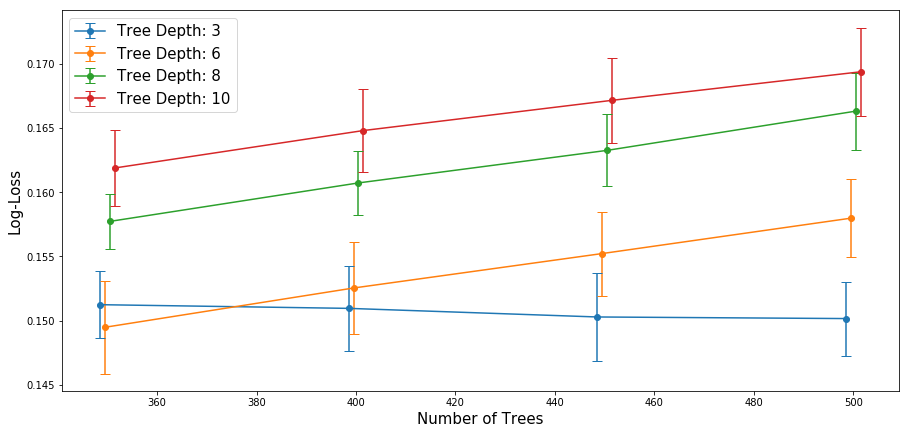

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [6]:
'''
Tune the number and size of trees using cross-validation.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'max_depth': [3, 6, 8, 10]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['max_depth'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset = [-1.5, -0.5, 0.5, 1.5]
for i, value in enumerate(searchGrid['max_depth']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Tree Depth: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell6'></a>

CPU times: user 868 ms, sys: 149 ms, total: 1.02 s
Wall time: 7min 53s

Best score: 0.149490632497, using {'n_estimators': 350, 'learning_rate': 0.1}

0.497641830379 +/- 0.00145373247688, with {'n_estimators': 350, 'learning_rate': 0.001}
0.477704186365 +/- 0.00146092659523, with {'n_estimators': 400, 'learning_rate': 0.001}
0.459162743548 +/- 0.00145253677425, with {'n_estimators': 450, 'learning_rate': 0.001}
0.441964584461 +/- 0.00143110401172, with {'n_estimators': 500, 'learning_rate': 0.001}
0.17490967938 +/- 0.00351436040952, with {'n_estimators': 350, 'learning_rate': 0.01}
0.169177599916 +/- 0.00375283546558, with {'n_estimators': 400, 'learning_rate': 0.01}
0.165052114061 +/- 0.00368898037535, with {'n_estimators': 450, 'learning_rate': 0.01}
0.162153262022 +/- 0.00360167526281, with {'n_estimators': 500, 'learning_rate': 0.01}
0.149490632497 +/- 0.00359407845941, with {'n_estimators': 350, 'learning_rate': 0.1}
0.152545937711 +/- 0.00356729822121, with {'n_estimators': 400, 

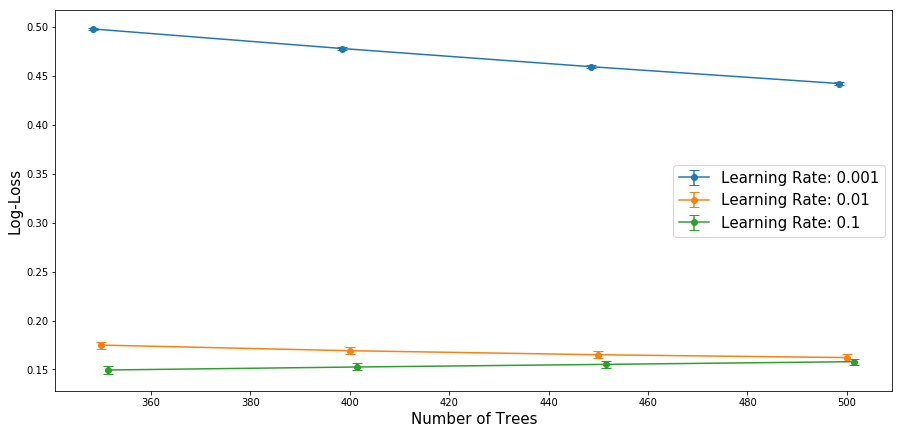

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [7]:
'''
Tune the learning rate and the number of trees using cross-validation.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'learning_rate': [0.001, 0.01, 0.1]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['learning_rate'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset  = [-1.5, 0.0, 1.5]
for i, value in enumerate(searchGrid['learning_rate']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Learning Rate: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell7'></a>

CPU times: user 543 ms, sys: 117 ms, total: 659 ms
Wall time: 3min 12s

Best score: 0.145385389501, using {'subsample': 0.5}

0.149385761895 +/- 0.00336073593446, with {'subsample': 0.4}
0.145385389501 +/- 0.00616625922086, with {'subsample': 0.5}
0.14753424433 +/- 0.00622499196307, with {'subsample': 0.6}
0.148347464994 +/- 0.002691628868, with {'subsample': 0.7}
0.148867049662 +/- 0.00615524549856, with {'subsample': 0.8}
0.148018952506 +/- 0.00522385105246, with {'subsample': 0.9}
0.149490632497 +/- 0.00359407845941, with {'subsample': 1.0}


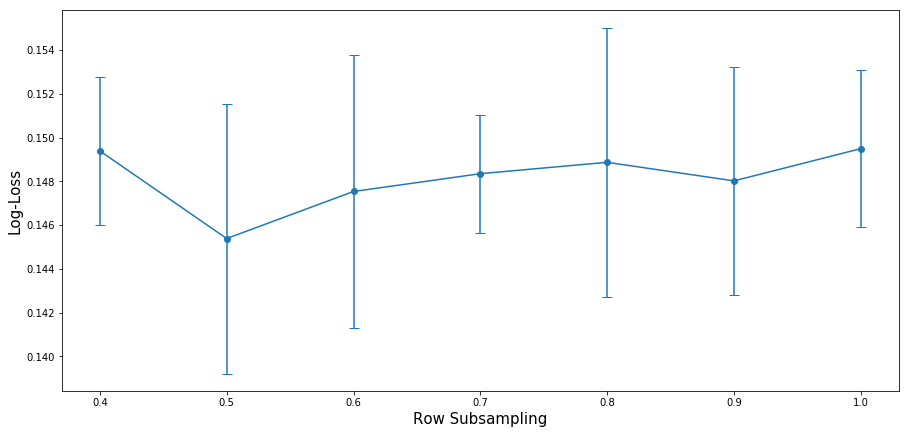

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1, 'silent': True, 'nthread': -1, 'subsample': 0.5, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [8]:
'''
Tune the row subsampling.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['subsample'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Row Subsampling', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell8'></a>

CPU times: user 547 ms, sys: 117 ms, total: 664 ms
Wall time: 2min 6s

Best score: 0.145385389501, using {'colsample_bytree': 1.0}

0.147023447587 +/- 0.00647977645258, with {'colsample_bytree': 0.4}
0.147824028832 +/- 0.00577041855917, with {'colsample_bytree': 0.5}
0.146226471609 +/- 0.0050502252622, with {'colsample_bytree': 0.6}
0.146637979621 +/- 0.00763411135629, with {'colsample_bytree': 0.7}
0.148902509928 +/- 0.00565740993408, with {'colsample_bytree': 0.8}
0.146015737801 +/- 0.00661005052914, with {'colsample_bytree': 0.9}
0.145385389501 +/- 0.00616625922086, with {'colsample_bytree': 1.0}


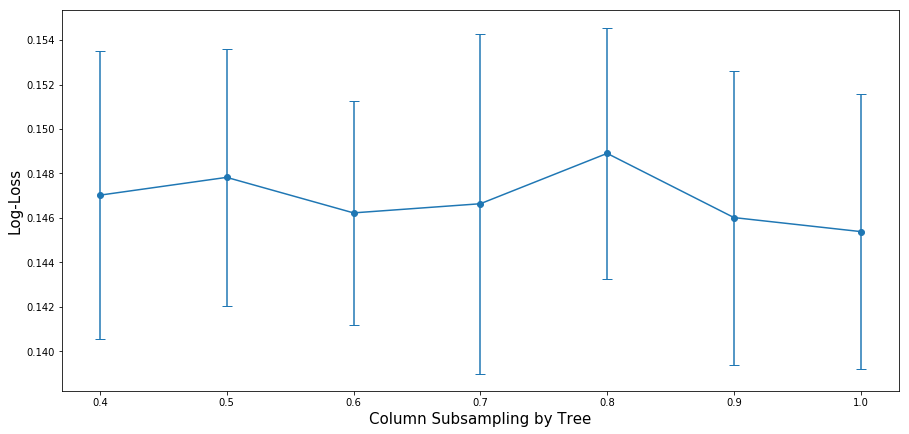

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.5, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [9]:
'''
Tune the column subsampling by tree.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bytree'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Tree', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell9'></a>

CPU times: user 546 ms, sys: 127 ms, total: 673 ms
Wall time: 2min

Best score: 0.145254928146, using {'colsample_bylevel': 0.9}

0.145685361399 +/- 0.00477172505889, with {'colsample_bylevel': 0.4}
0.147274233977 +/- 0.000879507854088, with {'colsample_bylevel': 0.5}
0.145887988783 +/- 0.004082068452, with {'colsample_bylevel': 0.6}
0.146222918074 +/- 0.00725208106435, with {'colsample_bylevel': 0.7}
0.147903069437 +/- 0.00472442903806, with {'colsample_bylevel': 0.8}
0.145254928146 +/- 0.00458550405777, with {'colsample_bylevel': 0.9}
0.145385389501 +/- 0.00616625922086, with {'colsample_bylevel': 1.0}


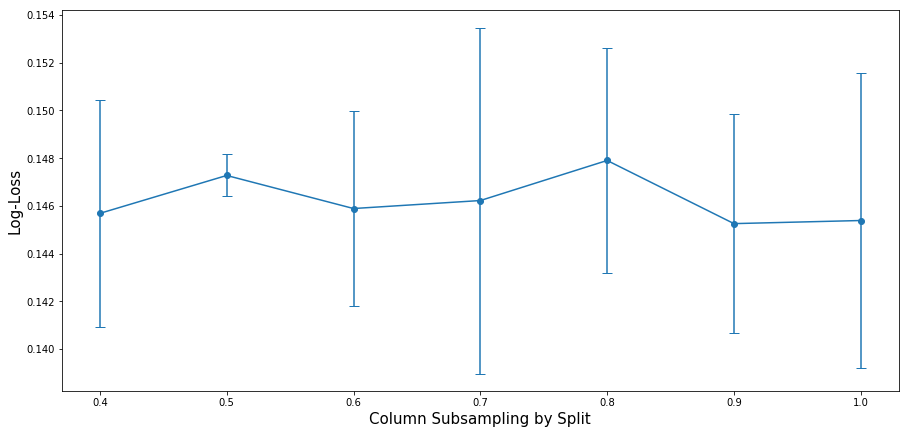

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.5, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [10]:
'''
Tune the column subsampling by split.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bylevel'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Split', fontsize=15)
plt.ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell10'></a>

CPU times: user 582 ms, sys: 119 ms, total: 701 ms
Wall time: 2min 44s

Best score: 0.14106624946, using {'reg_alpha': 1.0}

0.145254744703 +/- 0.00458550061523, with {'reg_alpha': 1e-05}
0.146717983716 +/- 0.00526686055199, with {'reg_alpha': 0.0001}
0.146755384659 +/- 0.00499788451186, with {'reg_alpha': 0.001}
0.145318053501 +/- 0.0074320902671, with {'reg_alpha': 0.01}
0.147210088588 +/- 0.00515018784723, with {'reg_alpha': 0.1}
0.14106624946 +/- 0.00223713356981, with {'reg_alpha': 1.0}
0.151077473693 +/- 0.00304918080548, with {'reg_alpha': 10.0}
0.268300328954 +/- 0.00165600819107, with {'reg_alpha': 100.0}


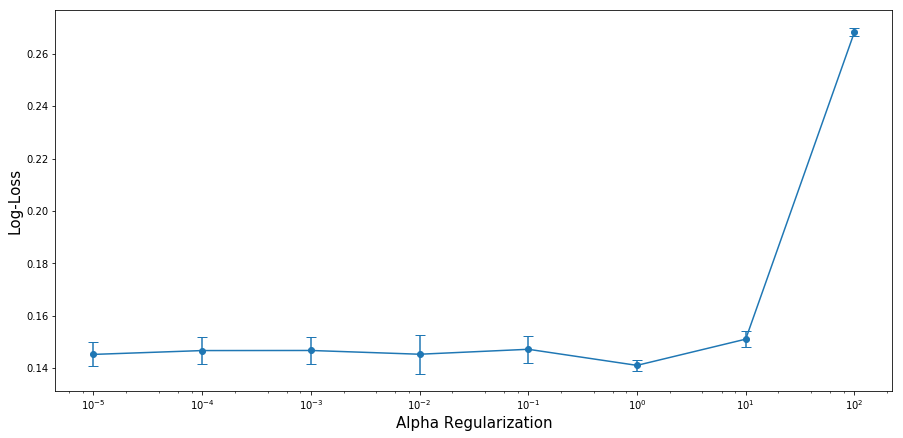

Updated settings: {'reg_alpha': 1.0, 'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.5, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 6}


In [11]:
'''
Tune the alpha regularization parameter.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'reg_alpha': [1.0E-05, 1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0, 100.0]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_alpha'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Alpha Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11'></a>

CPU times: user 410 ms, sys: 106 ms, total: 516 ms
Wall time: 2min 3s

Best score: 0.140220562992, using {'reg_lambda': 10.0}

0.145621035585 +/- 0.00237211815504, with {'reg_lambda': 0.01}
0.144402766883 +/- 0.00500053475305, with {'reg_lambda': 0.1}
0.14106624946 +/- 0.00223713356981, with {'reg_lambda': 1.0}
0.140220562992 +/- 0.0032052902207, with {'reg_lambda': 10.0}
0.155814600957 +/- 0.00298858755476, with {'reg_lambda': 100.0}


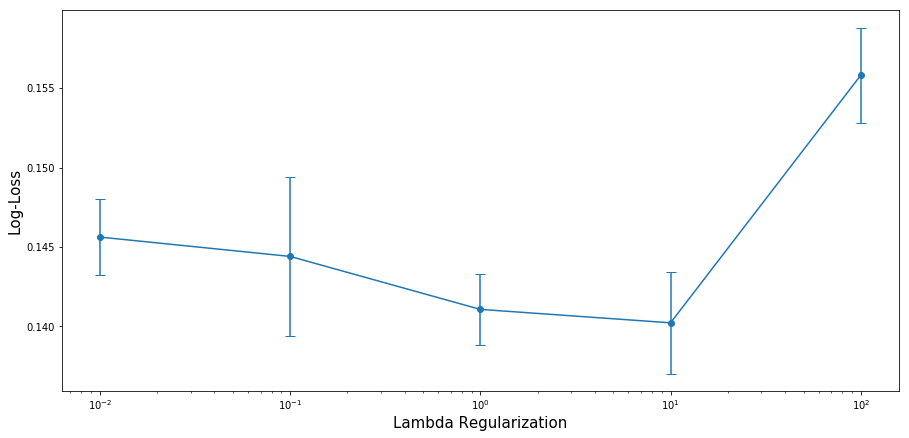

Updated settings: {'reg_alpha': 1.0, 'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'n_estimators': 350, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.5, 'reg_lambda': 10.0, 'objective': 'binary:logistic', 'max_depth': 6}


In [12]:
'''
Tune the lambda regularization parameter.
'''
# Grid search
xgb1 = XGBClassifier(**defaults)
searchGrid = {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}
kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
gSearch    = GridSearchCV(xgb1, searchGrid, scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
%time gSearch.fit(df_train_X, df_train_y)

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_lambda'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Lambda Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Log-Loss', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

## Fit model to training subset of training sample and check properties on test subset.

<a id='Cell12'></a>

In [13]:
'''
Create separate models for each of the ten turbines, using cross-validation.
'''

defaults = {'objective': 'binary:logistic', 'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.1, 
            'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 
            'reg_alpha': 1.0, 'reg_lambda': 10.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

searchGrids = [{'learning_rate': [0.1, 0.03, 0.01]}, 
               {'max_depth': [4, 6, 8, 10, 12]},
               {'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
               {'reg_alpha': [1.0E-05, 1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0, 100.0]},
               {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}]
                    
nturbines      = 10
settings       = [defaults.copy() for _ in xrange(nturbines)]
xgbc_train_all = []
kfold          = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for (target, setting, df_train_X, df_train_y) in zip(targets, settings, dfs_train_X, dfs_train_y):
    print('\nFitting turbine {0}...'.format(target[10:]))
    for grid in searchGrids:
        gSearch = GridSearchCV(estimator=XGBClassifier(**setting), param_grid=grid, 
                               scoring='neg_log_loss', n_jobs=-1, cv=kfold, refit=False)
        gSearch.fit(df_train_X, df_train_y)
        setting.update(gSearch.best_params_)
        print('   Updated parameters: {0}, best score: {1}'.format(gSearch.best_params_, gSearch.best_score_))
    xgb1 = XGBClassifier(**setting)
    xgb1.fit(df_train_X, df_train_y, eval_metric=["logloss"], verbose=False)
    xgbc_train_all.append(xgb1)
    
# Save the models to disk.
fName = 'xgbc_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbc_train_all, path_to_file)
print('Extreme gradient boosting classifier model saved to {0}'.format(path_to_file))


Fitting turbine 1...
   Updated parameters: {'learning_rate': 0.1}, best score: -0.140220562992
   Updated parameters: {'max_depth': 12}, best score: -0.138972641202
   Updated parameters: {'subsample': 0.7}, best score: -0.138524418603
   Updated parameters: {'colsample_bytree': 0.4}, best score: -0.138238479813
   Updated parameters: {'colsample_bylevel': 0.9}, best score: -0.138238479813
   Updated parameters: {'reg_alpha': 0.0001}, best score: -0.137291212423
   Updated parameters: {'reg_lambda': 10.0}, best score: -0.137291212423

Fitting turbine 2...
   Updated parameters: {'learning_rate': 0.1}, best score: -0.0614932691916
   Updated parameters: {'max_depth': 12}, best score: -0.0611426662858
   Updated parameters: {'subsample': 0.9}, best score: -0.0589734991899
   Updated parameters: {'colsample_bytree': 1.0}, best score: -0.0589734991899
   Updated parameters: {'colsample_bylevel': 0.9}, best score: -0.0589734991899
   Updated parameters: {'reg_alpha': 1.0}, best score: -0.

<a id='Cell13'></a>

In [22]:
'''
Retrieve from disk models that were trained on the training subsample only. 
We'll need both a regressor model and a classifier model.
'''

xgbr_found = True
xgbc_found = True

try:
    xgbc_train_all
except:
    fName = 'xgbc_train_2017_04_04_01_54_32'
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbc_train_all = joblib.load(path_to_file) 
    except:
        print('Error loading classifier model from {0}\n'.format(path_to_file))
        xgbc_found = False
    else:
        print('Classifier model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Classifier model already exists, not updated from file!\n')

try:
    xgbr_train_all
except:
    fName = 'xgbr_train_2017_03_28_04_50_26'
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_train_all = joblib.load(path_to_file)
    except:
        print('Error loading regressor model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regressor model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Regressor model already exists, not updated from file!\n')

if xgbr_found and xgbc_found:
    for ind, (xgbc, xgbr) in enumerate(zip(xgbc_train_all, xgbr_train_all)):
        print('Turbine {0}:\nClassifier: {1}\nRegressor: {2}\n'.format(ind+1, xgbc, xgbr))
elif xgbr_found:
    for ind, xgbr in enumerate(xgbr_train_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))
elif xgbc_found:
    for ind, xgbc in enumerate(xgbc_train_all):
        print('Turbine {0}:\nClassifier: {1}\n'.format(ind+1, xgbc))

Classifier model already exists, not updated from file!

Regressor model successfully loaded from fitted_models/xgbr_train_2017_03_28_04_50_26.model

Turbine 1:
Classifier: XGBClassifier(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=350, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0001, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Classifier: XGBClassifier(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1

<a id='Cell14'></a>

In [15]:
'''
Test the fitted models on the testing subset.
'''

Nturbines   = len(xgbc_train_all)
Acc_Train   = []
Acc_Test    = []
Acc0_Train  = []
Acc0_Test   = []
Train_Total = len(df_train_X)
Test_Total  = len(df_test_X)

for ind, (xgb, df_train_X, df_train_y, df_test_X, df_test_y) \
in enumerate(zip(xgbc_train_all, dfs_train_X, dfs_train_y, dfs_test_X, dfs_test_y)):
    
    target = 'TARGETVAR_'+str(ind+1)
    
    # Predict training set and testing set
    df_train_ypred = xgb.predict(df_train_X)
    df_test_ypred  = xgb.predict(df_test_X)
    
    # Compute performance measures
    Acc_Train.append(accuracy_score(df_train_y, df_train_ypred))
    Acc_Test.append(accuracy_score(df_test_y, df_test_ypred))
    CM_Train  = confusion_matrix(df_train_y, df_train_ypred)
    CM_Test   = confusion_matrix(df_test_y, df_test_ypred)
    A0_Train  = float(CM_Train[1][1]+CM_Train[1][0])/Train_Total
    A0_Train  = max(A0_Train, 1.0-A0_Train)
    A0_Test   = float(CM_Test[1][1]+CM_Test[1][0])/Test_Total
    A0_Test   = max(A0_Test, 1.0-A0_Test)
    Acc0_Train.append(A0_Train)
    Acc0_Test.append(A0_Test)
    
    # Print model report
    print('\nModel Report for Turbine {0}'.format(ind+1))
    print('On training set: Accuracy: {0}, Benchmark: {1}'.format(Acc_Train[-1], Acc0_Train[-1]))
    print('                 Confusion Matrix: tn={0}, fp={1}, fn={2}, tp={3}'\
          .format(CM_Train[0][0], CM_Train[0][1], CM_Train[1][0], CM_Train[1][1]))
    print('On testing set:  Accuracy: {0}, Benchmark: {1}'.format(Acc_Test[-1], Acc0_Test[-1]))
    print('                 Confusion Matrix: tn={0}, fp={1}, fn={2}, tp={3}'\
          .format(CM_Test[0][0], CM_Test[0][1], CM_Test[1][0], CM_Test[1][1]))

print('\nAverage accuracy on training set: {0}, benchmark: {1}'\
      .format(np.array(Acc_Train).mean(), np.array(Acc0_Train).mean()))
print('Average accuracy on testing set:  {0}, benchmark: {1}'\
      .format(np.array(Acc_Test).mean(), np.array(Acc0_Test).mean()))


Model Report for Turbine 1
On training set: Accuracy: 0.9997, Benchmark: 0.9004
                 Confusion Matrix: tn=9004, fp=0, fn=3, tp=993
On testing set:  Accuracy: 0.95065874451, Benchmark: 0.900542495479
                 Confusion Matrix: tn=3447, fp=39, fn=152, tp=233

Model Report for Turbine 2
On training set: Accuracy: 0.9998, Benchmark: 0.9757
                 Confusion Matrix: tn=9757, fp=0, fn=2, tp=241
On testing set:  Accuracy: 0.983208473263, Benchmark: 0.975716869026
                 Confusion Matrix: tn=3771, fp=6, fn=59, tp=35

Model Report for Turbine 3
On training set: Accuracy: 0.9996, Benchmark: 0.9361
                 Confusion Matrix: tn=9361, fp=0, fn=4, tp=635
On testing set:  Accuracy: 0.9640919659, Benchmark: 0.936192198398
                 Confusion Matrix: tn=3594, fp=30, fn=109, tp=138

Model Report for Turbine 4
On training set: Accuracy: 0.9981, Benchmark: 0.9547
                 Confusion Matrix: tn=9547, fp=0, fn=19, tp=434
On testing set:  Accurac

<a id='Cell15'></a>

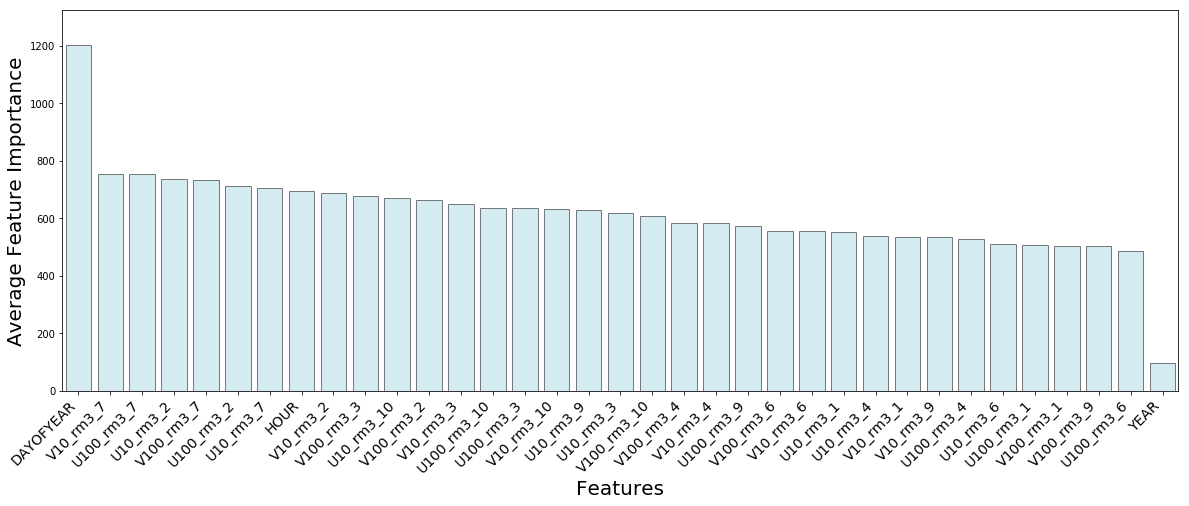

In [16]:
'''
Plot feature importances averaged over all turbines.
'''
%matplotlib inline
all_feat_imp = []
for xgb in xgbc_train_all:
    all_feat_imp.append(xgb.booster().get_score(importance_type='weight'))
all_feat_imp_df = pd.DataFrame(all_feat_imp)
feat_imp        = all_feat_imp_df.mean().sort_values(ascending=False)
n_features      = min(50,len(feat_imp))
bins            = np.arange(n_features)
x_labels        = feat_imp.index.values[:n_features]
y_values        = feat_imp.values[:n_features]
maxHeight       = 1.10*max(y_values)

fig, axes  = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.bar(bins, y_values, align="center", color="lightblue", edgecolor="k", alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=14)
axes.set_xlim([-0.5,bins.size-0.5])
if len(feat_imp) <= 50:
    axes.set_xlabel('Features'.format(n_features), fontsize=20)
else:
    axes.set_xlabel('Top {0} Features'.format(n_features), fontsize=20)
axes.set_ylim([0.0, maxHeight])
axes.set_ylabel('Average Feature Importance', fontsize=20)
plt.show()
#fig.savefig(save, dpi=200, bbox_inches='tight')

<a id='Cell16'></a>

In [23]:
'''
Compare xgbc and xgbr on their ability to identify zero turbine output events in the test set.
'''
pos = 1
neg = 1-pos
print('            Cp:Rn  Cn:Rp  Cp:Rp  Cn:Rn\n            --------------------------')
for ind, (xgbr, xgbc, df_test_X, df_test_y) \
in enumerate(zip(xgbr_train_all, xgbc_train_all, dfs_test_X, dfs_test_y)):
    df_test_ypredr  = [pos if x<=0 else 1-pos for x in xgbr.predict(df_test_X)]
    df_test_ypredc  = xgbc.predict(df_test_X)
    Nppp = [y==pos and yc==pos and yr==pos for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Nppn = [y==pos and yc==pos and yr==neg for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Npnp = [y==pos and yc==neg and yr==pos for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Npnn = [y==pos and yc==neg and yr==neg for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Np   = Nppp + Nppn + Npnp + Npnn
    Nnnn = [y==neg and yc==neg and yr==neg for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Nnnp = [y==neg and yc==neg and yr==pos for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Nnpn = [y==neg and yc==pos and yr==neg for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Nnpp = [y==neg and yc==pos and yr==pos for (y,yc,yr) in zip(df_test_y,df_test_ypredc,df_test_ypredr)].count(True)
    Nn   = Nnnn + Nnnp + Nnpn + Nnpp
    Na   = Np + Nn
    print('\nTurbine {0:2d}: {1:4d}   {2:4d}   {3:4d}   {4:4d} | {5:4d}'.format(ind+1, Nppn, Npnp, Nppp, Npnn, Np))
    print('            {0:4d}   {1:4d}   {2:4d}   {3:4d} | {4:4d}'.format(Nnpn, Nnnp, Nnpp, Nnnn, Nn))
    print('            --------------------------|-----')
    print('            {0:4d}   {1:4d}   {2:4d}   {3:4d} | {4:4d}'.format(Nppn+Nnpn,Npnp+Nnnp,Nppp+Nnpp,Npnn+Nnnn,Na))
    CpRn = 'Cp'
    CnRp = 'Rp'
    CpRp = 'Ap'
    CnRn = 'An'
    if Nppn < Nnpn: CpRn = 'Rn'
    if Npnp < Nnnp: CnRp = 'Cn'
    if Nppp < Nnpp: CpRp = 'On'
    if Npnn > Nnnn: CnRn = 'Op'
    print('              {0}     {1}     {2}     {3}'.format(CpRn,CnRp,CpRp,CnRn))

            Cp:Rn  Cn:Rp  Cp:Rp  Cn:Rn
            --------------------------

Turbine  1:  129     25    104    127 |  385
              36      4      3   3443 | 3486
            --------------------------|-----
             165     29    107   3570 | 3871
              Cp     Rp     Ap     An

Turbine  2:   20     14     15     45 |   94
               1     10      5   3761 | 3777
            --------------------------|-----
              21     24     20   3806 | 3871
              Cp     Rp     Ap     An

Turbine  3:   84     17     54     92 |  247
              27      9      3   3585 | 3624
            --------------------------|-----
             111     26     57   3677 | 3871
              Cp     Rp     Ap     An

Turbine  4:   41     30     27     77 |  175
               2     68      1   3625 | 3696
            --------------------------|-----
              43     98     28   3702 | 3871
              Cp     Cn     Ap     An

Turbine  5:   94     33     82    100 |  309


<a id='Cell17'></a>

In [24]:
'''
Compute RMSE on test set, with and without the classifier correction, and compare.
'''
Nturbines       = len(xgbc_train_all)
MSE_Test1_Total = 0.0
MSE_Test2_Total = 0.0

for ind, (xgbr, xgbc, df_test_X, df_test_yt) \
in enumerate(zip(xgbr_train_all, xgbc_train_all, dfs_test_X, dfs_test_yt)):
    df_test_ypredr  = [min(max(x,0.0),1.0) for x in xgbr.predict(df_test_X)]
    df_test_ypredc  = xgbc.predict(df_test_X)
    df_test_ypredrc = [0 if (c==pos and r<0.05) else r for (r,c) in zip(df_test_ypredr, df_test_ypredc)]

    MSE_Test1       = mean_squared_error(df_test_yt, df_test_ypredr)
    MSE_Test2       = mean_squared_error(df_test_yt, df_test_ypredrc)
    MSE_Test1_Total += MSE_Test1
    MSE_Test2_Total += MSE_Test2
    print('Turbine {0:2d} RMSE: {1} (uncorrected), {2} (corrected)'\
          .format(ind+1, np.sqrt(MSE_Test1), np.sqrt(MSE_Test2)))
          
RMSE1 = np.sqrt(MSE_Test1_Total/Nturbines)
RMSE2 = np.sqrt(MSE_Test2_Total/Nturbines)
print('\nTotal RMSE: {0} (uncorrected), {1} (corrected)'.format(RMSE1, RMSE2))

Turbine  1 RMSE: 0.0464933454963 (uncorrected), 0.0464942565398 (corrected)
Turbine  2 RMSE: 0.0472321521015 (uncorrected), 0.0472120810949 (corrected)
Turbine  3 RMSE: 0.0529656718547 (uncorrected), 0.0529353834238 (corrected)
Turbine  4 RMSE: 0.0595246715409 (uncorrected), 0.05951043546 (corrected)
Turbine  5 RMSE: 0.0570910558318 (uncorrected), 0.0570694040351 (corrected)
Turbine  6 RMSE: 0.0575522882295 (uncorrected), 0.0575346198916 (corrected)
Turbine  7 RMSE: 0.0443942354211 (uncorrected), 0.0443923532497 (corrected)
Turbine  8 RMSE: 0.0579820875623 (uncorrected), 0.0579552572462 (corrected)
Turbine  9 RMSE: 0.0527395550625 (uncorrected), 0.0526687519577 (corrected)
Turbine 10 RMSE: 0.0646707177136 (uncorrected), 0.0646944715124 (corrected)

Total RMSE: 0.0544143766257 (uncorrected), 0.0543970197244 (corrected)


## Refit model to entire training data set and create solution file.

<a id='Cell18'></a>

In [25]:
'''
Refit model with final settings to entire training data set and save fitted model to disk.
'''
xgbc_all = []
for target, setting in zip(targets, settings):
    xgbc = XGBClassifier(**setting)
    %time xgbc.fit(df0[predictors], df0[target], eval_metric=["logloss"], verbose=False)
    xgbc_all.append(xgbc)
    
fName = 'xgbc_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbc_all, path_to_file)
print('\nExtreme gradient boosting classifier model saved to {0}'.format(path_to_file))

CPU times: user 21.1 s, sys: 134 ms, total: 21.2 s
Wall time: 21.5 s
CPU times: user 39.7 s, sys: 567 ms, total: 40.2 s
Wall time: 43 s
CPU times: user 32.9 s, sys: 242 ms, total: 33.1 s
Wall time: 33.7 s
CPU times: user 19.6 s, sys: 96.1 ms, total: 19.7 s
Wall time: 20.1 s
CPU times: user 22.2 s, sys: 104 ms, total: 22.3 s
Wall time: 22.5 s
CPU times: user 34.4 s, sys: 157 ms, total: 34.5 s
Wall time: 35.3 s
CPU times: user 41.3 s, sys: 189 ms, total: 41.4 s
Wall time: 41.7 s
CPU times: user 57.1 s, sys: 229 ms, total: 57.4 s
Wall time: 57.7 s
CPU times: user 38.3 s, sys: 380 ms, total: 38.7 s
Wall time: 40.4 s
CPU times: user 37.5 s, sys: 499 ms, total: 38 s
Wall time: 39.8 s

Extreme gradient boosting classifier model saved to fitted_models/xgbc_2017_04_04_02_17_20.model


<a id='Cell19'></a>

In [2]:
'''
Retrieve trained models from disk. We'll need both a regressor model and
a classifier model.
'''
xgbc_found = True
xgbr_found = True

try:
    xgbc_all
except:
#    fName = 'xgbc_2017_03_08_17_24_52'
#    fName = 'xgbc_2017_03_11_01_57_56' # Rolling average over 3 measurements
    fName = 'xgbc_2017_04_04_02_17_20' # rm=3, dups removed
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbc_all = joblib.load(path_to_file)
    except:
        print('Error loading classifier model from {0}\n'.format(path_to_file))
        xgbc_found = False
    else:
        print('Classifier model successfully loaded from {0}\n'.format(path_to_file))
else:
    print('Classifier model already exists, not updated from file!\n')

try:
    xgbr_all
except:
#    fName = 'xgb_2017_03_05_17_57_26'
#    fName = 'xgbr_2017_03_10_22_09_58' # Rolling average over 3 measurements
    fName = 'xgbr_2017_03_28_07_24_58' # rm=3, dups removed
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_all = joblib.load(path_to_file)
    except:
        print('Error loading regressor model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regressor model successfully loaded from {0}\n'.format(path_to_file))
else:
    print('Regressor model already exists, not updated from file!\n')

if xgbc_found and xgbr_found:
    for ind, (xgbc, xgbr) in enumerate(zip(xgbc_all, xgbr_all)):
        print('Turbine {0}:\nClassifier: {1}\nRegressor: {2}\n'.format(ind+1, xgbc, xgbr))
elif xgbc_found:
    for ind, xgbc in enumerate(xgbc_all):
        print('Turbine {0}:\nClassifier: {1}\n'.format(ind+1, xgbc))
elif xgbr_found:
    for ind, xgbr in enumerate(xgbr_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Classifier model successfully loaded from fitted_models/xgbc_2017_04_04_02_17_20.model

Regressor model successfully loaded from fitted_models/xgbr_2017_03_28_07_24_58.model

Turbine 1:
Classifier: XGBClassifier(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=nan, n_estimators=350, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0001, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Classifier: XGBClassifier(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=1.0,
       ga

<a id='Cell20'></a>

In [6]:
'''
Prepare the test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Load the testing data
#TestingDataFile = "data/Test_pp_2017_03_02_15_47_36.pkl"
#TestingDataFile = "data/Test_pp_2017_03_10_15_38_00.pkl" # With rolling average over 3 measurements
TestingDataFile = "data/Test_pp_2017_03_28_09_02_52.pkl" # rm=3, dups removed
df1             = pd.read_pickle(TestingDataFile)

# Rename dataframe columns and make lists with the new predictor labels
predictors  = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]!='ID']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
ids         = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]=='ID']
df1.columns = ids+predictors

# Count how many sets of observations we have in August and September 2013
nTotal      = len(df1)
nAugSep2013 = len([DoY for DoY in df1['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            {0}'.format(nTotal))
print('Number of observation times in August and September 2013: {0}\n'.format(nAugSep2013))

# Compute predictions
pos             = 1
df1_ids         = []
df1_predictions = []
for ind, (xgbc, xgbr) in enumerate(zip(xgbc_all, xgbr_all)):
    obs_id = 'ID_'+str(ind+1)
    print('obs_id = {0}'.format(obs_id))
    df1_ids.extend(df1[obs_id].tolist())
    df1_regr = [min(max(x,0.0),1.0) for x in xgbr.predict(df1[predictors])]
    df1_clas = xgbc.predict(df1[predictors])
#    df1_predictions.extend([0 if (c==pos and r<0.05) else r for (r,c) in zip(df1_regr,df1_clas)])
    if ind==3:
        df1_predictions.extend([0 if c==pos else r for (r,c) in zip(df1_regr, df1_clas)])
    else:
        df1_predictions.extend([r if (c!=pos and r>0.0) else 0 for (r,c) in zip(df1_regr, df1_clas)])

# Generate output csv file
fName = 'xgbrc_' + strftime("%Y_%m_%d_%H_%M_%S")
fName_out = 'data/' + fName + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID","TARGETVAR"])
    for idval,yval in zip(df1_ids, df1_predictions):
        writer.writerow([idval,yval])
print('Output written to {0}'.format(fName_out))


Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

obs_id = ID_1
obs_id = ID_2
obs_id = ID_3
obs_id = ID_4
obs_id = ID_5
obs_id = ID_6
obs_id = ID_7
obs_id = ID_8
obs_id = ID_9
obs_id = ID_10
Output written to data/xgbrc_2017_04_04_11_37_56.out.csv
